In [1]:
import polars as pl
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import logging
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(tf.__version__)

2024-06-15 14:53:19.659523: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 14:53:19.722425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 14:53:20.715773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

history = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

columns = [
    'device_type', 'read_time', 'scroll_percentage', 'is_sso_user', 'gender', 'age', 'is_subscriber', 'postcode',
    'trendiness_score_1d', 'trendiness_score_3d', 'weekday', 'hour', 'trendiness_score_1d/3d', 
    'normalized_trendiness_score_overall', 'premium', 'category', 'sentiment_score', 'sentiment_label', 
    'num_images', 'title_len', 'subtitle_len', 'body_len', 'num_topics', 'total_pageviews', 'total_inviews',
    'total_read_time', 'total_pageviews/inviews', 'article_type', 'article_delay_days', 'article_delay_hours', 
    'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
    'Entity_EVENT_Present', 'Entity_PER_Present', 'mean_user_trendiness_score', 'mean_topics_trendiness_score',
    'is_inside_window_0', 'is_inside_window_1', 'is_inside_window_2', 'is_inside_window_3', 'window_category_score',
    'window_topics_score', 'trendiness_score_category', 'endorsement_10h', 'normalized_endorsement_10h',
    'endorsement_10h_diff_rolling', 'endorsement_macd', 'endorsement_quantile_norm_10h',
    'normalized_endorsement_10h_rolling_max_ratio', 'endorsement_20h_articleuser', 'normalized_endorsement_articleuser_20h',
    'endorsement_20h_articleuser_diff_rolling', 'endorsement_articleuser_macd', 'endorsement_articleuser_quantile_norm_20h',
    'normalized_endorsement_articleuser_20h_rolling_max_ratio', 'last_session_duration', 'mean_prev_sessions_duration',
    'last_session_time_hour_diff', 'is_new_article', 'is_already_seen_article', 'yesterday_category_daily_pct',
    'target', 'user_id'
]
behaviors = pl.scan_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet').select(columns).collect()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'postcode', 'weekday', 'premium', 'category',
                       'sentiment_label', 'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
                       'Entity_EVENT_Present', 'Entity_PER_Present', 'article_type']
numerical_columns = [c for c in columns if c not in categorical_columns + ['target', 'user_id', 'impression_id', 'article']]

behaviors_pandas = behaviors.to_pandas()

xformer = PowerTransformer()
behaviors_pandas[numerical_columns] = xformer.fit_transform(behaviors_pandas[numerical_columns]).astype(np.float32)

encoder = OrdinalEncoder()
behaviors_pandas[categorical_columns] = encoder.fit_transform(behaviors_pandas[categorical_columns]).astype(np.int16)
behaviors = behaviors.select(['target', 'user_id']).hstack(pl.from_pandas(behaviors_pandas[numerical_columns + categorical_columns]))

history_seq = build_history_seq(history, articles)

history_seq.head(3)

/home/ubuntu/RecSysChallenge2024/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/ubuntu/RecSysChallenge2024/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Memory usage of dataframe is 40.75 MB
Memory usage after optimization is: 5.12 MB
Decreased by 87.4%


user_id,weekday,scroll_percentage,sentiment_label,category,hour_group,read_time,premium,topics_0,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8,topics_9,topics_10,topics_11,topics_12,topics_13,topics_14,topics_15,topics_16,topics_17,topics_18,topics_19,topics_20,topics_21,topics_22,topics_23,topics_24,topics_25,topics_26,topics_27,topics_28,…,subcategory_137,subcategory_138,subcategory_139,subcategory_140,subcategory_141,subcategory_142,subcategory_143,subcategory_144,subcategory_145,subcategory_146,subcategory_147,subcategory_148,subcategory_149,subcategory_150,subcategory_151,subcategory_152,subcategory_153,subcategory_154,subcategory_155,subcategory_156,subcategory_157,subcategory_158,subcategory_159,subcategory_160,subcategory_161,subcategory_162,subcategory_163,subcategory_164,subcategory_165,subcategory_166,subcategory_167,subcategory_168,subcategory_169,subcategory_170,subcategory_171,subcategory_172,subcategory_173
u32,list[i8],list[f32],list[i8],list[i8],list[i8],list[f32],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],…,list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8]
2424720,"[6, 6, … 3]","[100.0, 29.0, … 40.0]","[1, 1, … 1]","[4, 4, … 4]","[2, 2, … 5]","[334.0, 99.0, … 8.0]","[0, 0, … 0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 1]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 1, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 1]","[0, 0, … 0]",…,"[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]"
1485660,"[4, 4, … 1]","[29.0, 49.0, … 55.0]","[1, 2, … 1]","[5, 7, … 10]","[2, 2, … 3]","[4.0, 24.0, … 12.0]","[0, 0, … 0]","[0, 1, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 1, … 1]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 0]","[0, 1, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]",…,"[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]"
678869,"[4, 4, … 4]","[21.0, 57.0, … 11.0]","[1, 1, … 1]","[4, 5, … 4]","[3, 3, … 0]","[10.0, 64.0, … 4.0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 1, … 1]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 

In [3]:
vocabulary_sizes = {
    feature: len(encoder.categories_[i]) for i, feature in enumerate(categorical_columns)
}

In [4]:
from polimi.utils.tf_models.utils.build_sequences import build_sequences_cls_iterator

window = 20
training_dataset = tf.data.Dataset.from_generator(
    lambda : build_sequences_cls_iterator(history_seq, behaviors, window=window),
    output_signature=(
        {
            'numerical_columns': tf.TensorSpec(shape=(len(numerical_columns),), dtype=tf.float32), # behaviors numerical columns
            **{c: tf.TensorSpec(shape=(1,), dtype=tf.int16) for c in categorical_columns}, # behaviors categorical columns
            'topics': tf.TensorSpec(shape=(window, 78), dtype=tf.int32), # topics
            'subcategories': tf.TensorSpec(shape=(window, 174), dtype=tf.int32), # subcategory
            'categories': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # category
            'weekdays': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # weekday
            'hour_groups': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # hour_group
            'sentiment_labels': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # sentiment_label
            'numerical_sequences': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # (premium, read_time, scroll_percentage)
        },
        tf.TensorSpec(shape=(1,), dtype=tf.float32), # target
    )
).batch(64).shuffle(buffer_size=1024)

In [5]:
from polimi.utils.tf_models import TemporalHistorySequenceModel, TemporalHistoryClassificationModel

model = TemporalHistoryClassificationModel(
    categorical_features=categorical_columns,
    numerical_features=numerical_columns,
    vocabulary_sizes=vocabulary_sizes,
    seq_embedding_dims={
        # adding, for the moment, one dim more to cover missings in non one-hot vectors
        'Input_topics': (78, 10, True),
        'Input_subcategory': (174, 10, True),
        'Input_category': (26, 10, False),
        'Input_weekday': (8, 3, False),
        'Input_hour_group': (7, 3, False),
        'Input_sentiment_label': (4, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
    dense_n_layers=1,
    dense_start_units=128,
)

In [6]:
model._build()

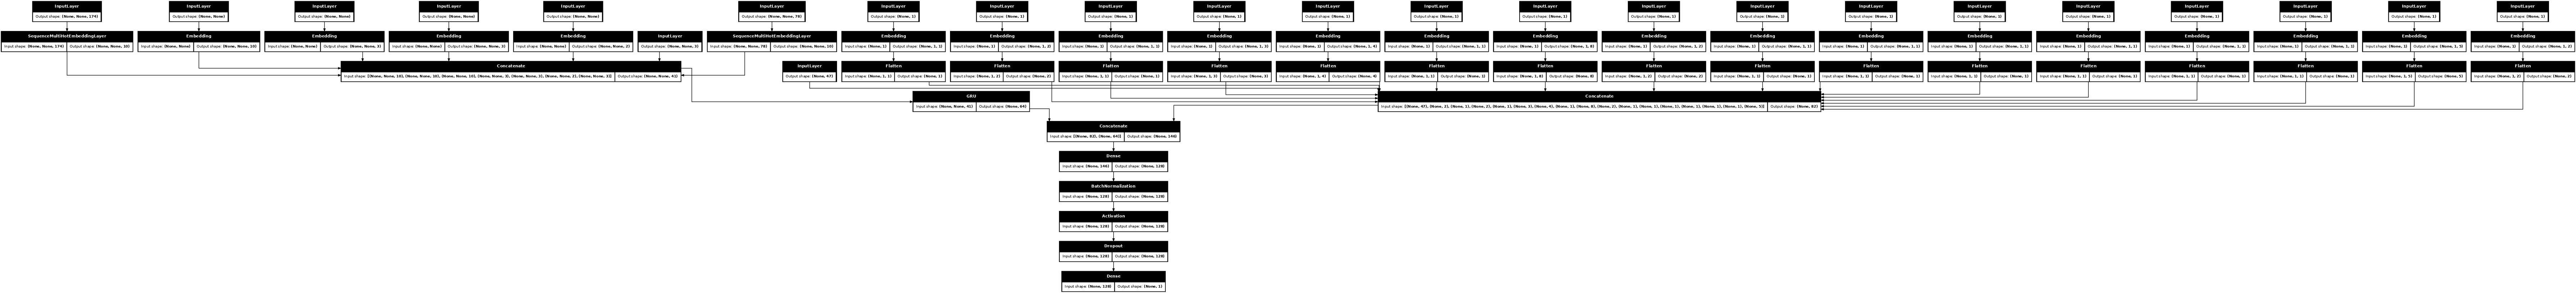

In [7]:
model.plot()

In [ ]:
model.fit(
    train_dataset=training_dataset,
    batch_size=64,
    epochs=10,
    # target for (topics, subcategory, category)
    loss={
        'Output_topics': tfk.losses.BinaryCrossentropy(), 
        'Output_subcategory': tfk.losses.BinaryCrossentropy(), 
        'Output_category': tfk.losses.CategoricalCrossentropy()
    },
    loss_weights={
        'Output_topics': 0.5, 
        'Output_subcategory': 0.1, 
        'Output_category': 0.4
    },
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)